## MIST demo

This notebook is a variation of the quickstart guide that walks through various model functionalities. 

In [1]:
import pandas as pd
from pathlib import Path
import copy

import numpy as np
import torch
from tqdm import tqdm
import pickle

from mist import utils
import mist.sirius.summarize_sirius as summarize_sirius
 

from mist.models import base
from mist.data import datasets, featurizers, data
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import Draw


/home/samlg/.conda/envs/ms-gen/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define constants

In [2]:
sirius_loc = "../sirius5/sirius/bin/sirius"
mgf_input = "../quickstart/quickstart.mgf"
extract_name = "notebook_quickstart"
target_directory = Path(f"../data/paired_spectra/{extract_name}")
target_directory.mkdir(exist_ok=True)
output_sirius = target_directory / "sirius_outputs"
target_spec = target_directory / "spec_files"
target_labels = target_directory / "labels.tsv"

## Data preprocessing

In [3]:
# Download models
!wget https://zenodo.org/record/7897299/files/mist_contrastive_canopus_pretrain.ckpt
!wget https://zenodo.org/record/7897299/files/mist_fp_canopus_pretrain.ckpt

!mv mist_contrastive_canopus_pretrain.ckpt ../pretrained_models/
!mv mist_fp_canopus_pretrain.ckpt ../pretrained_models/

--2023-06-26 13:42:35--  https://zenodo.org/record/7897299/files/mist_contrastive_canopus_pretrain.ckpt
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64183866 (61M) [application/octet-stream]
Saving to: ‘mist_contrastive_canopus_pretrain.ckpt’

mist_contrastive_ca 100%[===================>]  61.21M  3.82MB/s    in 73s     

2023-06-26 13:43:49 (858 KB/s) - ‘mist_contrastive_canopus_pretrain.ckpt’ saved [64183866/64183866]

--2023-06-26 13:43:49--  https://zenodo.org/record/7897299/files/mist_fp_canopus_pretrain.ckpt
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59984384 (57M) [application/octet-stream]
Saving to: ‘mist_fp_canopus_pretrain.ckpt’

mist_fp_canopus_pre 100%[===================>]  57.21M  5.59MB/s    in 42s     


## Running sirius formula assignments and tree building

A key requirement of MIST is that we have the MS1 precursor formula, along with subformula assigned. Currently SIRIUS is used for this step, though we plan to replace this in future iterations.

In [4]:
!$sirius_loc --no-compression --output $output_sirius --input $mgf_input formula --ppm-max-ms2 10 #--tree-timeout 120

Jun 26, 2023 1:44:33 PM org.apache.commons.beanutils.FluentPropertyBeanIntrospector introspect
INFO: Error when creating PropertyDescriptor for public final void org.apache.commons.configuration2.AbstractConfiguration.setProperty(java.lang.String,java.lang.Object)! Ignoring this property.
INFO    13:44:33 - Sirius Workspace Successfull initialized at: /home/samlg/.sirius-5.6
INFO    13:44:33 - You run SIRIUS 5.6.3
INFO    13:44:33 - You run SIRIUS in 'CLI' mode.
INFO    13:44:33 - Sirius was compiled with the following ILP solvers: GLPK-v1.7.0 (included), Gurobi-v9.1.1, CPLEX-v12.7.1, COIN-OR-v1.17.3
INFO    13:44:33 - Treebuilder priorities loaded from 'sirius.properties' are: [CLP, GUROBI, CPLEX]
INFO    13:44:33 - CPU check done. 64 cores that handle 128 threads were found.
INFO    13:44:38 - Web API initialized.
INFO    13:44:39 - Running with following arguments: [--no-compression, --output, ../data/paired_spectra/notebook_quickstart/sirius_outputs, --input, ../quickstart/quicksta

In [5]:
# Create summary statistics and df
summarize_sirius.main(labels_file=None,sirius_folder=output_sirius)

# View outputs
!ls $output_sirius | head

100%|██████████| 4/4 [00:00<00:00, 327.43it/s]

1_quickstart_107
2_quickstart_120
3_quickstart_126
4_quickstart_134
5_quickstart_146
6_quickstart_157
7_quickstart_188
summary_statistics


In [6]:
new_labels = summarize_sirius.build_new_labels(sirius_summary=output_sirius / "summary_statistics/summary_df.tsv",
                                               dataset_name=extract_name)
# Filter to only [M+H]+
new_labels = new_labels[new_labels["ionization"] == "[M+H]+"]

In [7]:
display(new_labels.head())
new_labels.to_csv(target_labels, sep="\t", index=False)

,spec,formula,ionization,dataset,compound,parentmass
0,quickstart_157,C8H15NO4,[M+H]+,notebook_quickstart,quickstart_157,190.106927
1,quickstart_134,C9H18N2O4,[M+H]+,notebook_quickstart,quickstart_134,219.135360
2,quickstart_120,C6H6N2O,[M+H]+,notebook_quickstart,quickstart_120,123.053904
3,quickstart_188,C6H6N2O2,[M+H]+,notebook_quickstart,quickstart_188,139.048765
6,quickstart_146,C7H7NO3,[M+H]+,notebook_quickstart,quickstart_146,154.049642


## Fingerprint prediction

In [8]:

fp_model = torch.load("../pretrained_models/mist_fp_canopus_pretrain.ckpt", map_location=torch.device("cpu"))
main_hparams = fp_model["hyper_parameters"]
fp_save_dir = Path("../quickstart/model_predictions")
fp_save_dir.mkdir(exist_ok=True)

main_hparams = fp_model["hyper_parameters"]
main_hparams["save_dir"] = fp_save_dir
main_hparams['dataset_name'] = extract_name
main_hparams['labels_name'] = "labels.tsv"
main_hparams['device'] = "cpu"
main_hparams['base_folder'] = "../data/paired_spectra/"
main_hparams['allow_none_smiles'] = True
main_hparams['output_targs'] = False
kwargs = main_hparams
device = torch.device("cpu")
model = base.build_model(**kwargs)
model.load_state_dict(fp_model["state_dict"])
model = model.to(device)
model = model.eval()

kwargs["spec_features"] = model.spec_features(mode="test")
kwargs['mol_features'] = "none"
paired_featurizer = featurizers.get_paired_featurizer(**kwargs)
# Ignore errors; we're just using this to get the featurizer
spectra_mol_pairs = datasets.get_paired_spectra(**kwargs)
spectra_mol_pairs = list(zip(*spectra_mol_pairs))

5it [00:00, 57932.38it/s]
0it [00:00, ?it/s]RDKit ERROR: [13:44:52] Invalid InChI prefix in generating InChI Key
[13:44:52] Invalid InChI prefix in generating InChI Key
RDKit ERROR: [13:44:52] Invalid InChI prefix in generating InChI Key
RDKit ERROR: [13:44:52] Invalid InChI prefix in generating InChI Key
RDKit ERROR: [13:44:52] Invalid InChI prefix in generating InChI Key
RDKit ERROR: [13:44:52] Invalid InChI prefix in generating InChI Key
5it [00:00, 9379.03it/s]
[13:44:52] Invalid InChI prefix in generating InChI Key
[13:44:52] Invalid InChI prefix in generating InChI Key
[13:44:52] Invalid InChI prefix in generating InChI Key
[13:44:52] Invalid InChI prefix in generating InChI Key
5it [00:00, 170500.16it/s]


In [9]:
test_dataset = datasets.SpectraMolDataset(
    spectra_mol_list=spectra_mol_pairs, featurizer=paired_featurizer, **kwargs
)
output_preds = (
    model.encode_all_spectras(test_dataset, no_grad=True, **kwargs).cpu().numpy()
)
output_names = test_dataset.get_spectra_names()

In [10]:
output_preds.sum(-1), output_preds.max(-1), output_preds.min(-1), output_preds.mean(-1)

(array([10.665705 , 23.242054 ,  8.696306 , 11.310223 ,  7.4023066],
       dtype=float32),
 array([0.5369164 , 0.8091661 , 0.5260056 , 0.50540346, 0.5462551 ],
       dtype=float32),
 array([3.1774205e-10, 4.2374444e-11, 3.5843294e-11, 4.7954729e-10,
        2.5004608e-11], dtype=float32),
 array([0.00260393, 0.00567433, 0.00212312, 0.00276128, 0.0018072 ],
       dtype=float32))

([<matplotlib.axis.YTick at 0x7f1efc1eec70>,
 [Text(0, 0, 'quickstart_157'),
  Text(0, 1, 'quickstart_134'),
  Text(0, 2, 'quickstart_120'),
  Text(0, 3, 'quickstart_188'),
  Text(0, 4, 'quickstart_146')])

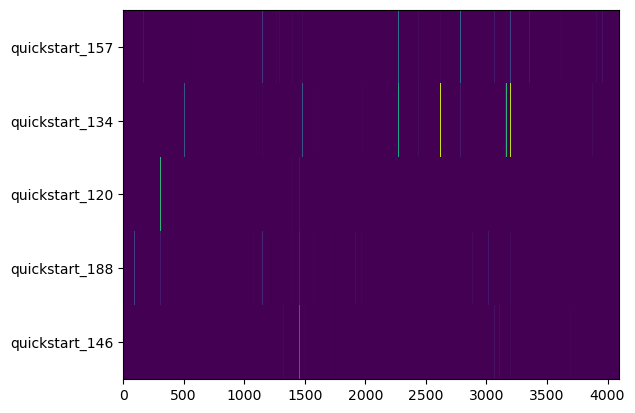

In [11]:
plt.imshow(output_preds, cmap="viridis", aspect="auto", interpolation="nearest")
plt.yticks(np.arange(len(output_preds)), output_names) #rotation=90)

In [12]:
result_export = {
    "dataset_name": extract_name,
    "names": output_names,
    "preds": output_preds,
    "targs": [None] * len(output_names),
    "args": kwargs,
    "split_name": "",
}
results_name = f"fp_preds_{extract_name}.p"
save_loc = Path(fp_save_dir).joinpath(results_name)
with open(save_loc, "wb") as fp:
    pickle.dump(result_export, fp)

## Contrastive embedding

In [13]:

contrast_model = torch.load("../pretrained_models/mist_contrastive_canopus_pretrain.ckpt", map_location=torch.device("cpu"))
main_hparams = contrast_model["hyper_parameters"]
fp_save_dir = Path("../quickstart/model_predictions")
fp_save_dir.mkdir(exist_ok=True)

main_hparams = contrast_model["hyper_parameters"]
main_hparams["save_dir"] = fp_save_dir
main_hparams['dataset_name'] = extract_name
main_hparams['labels_name'] = "labels.tsv"
main_hparams['device'] = "cpu"
main_hparams['base_folder'] = "../data/paired_spectra/"
main_hparams['allow_none_smiles'] = True
main_hparams['output_targs'] = False


base_params = main_hparams["base_model_hparams"]
main_hparams["base_model_hparams"] = copy.deepcopy(base_params)
base_params.update(main_hparams)
kwargs = base_params

device = torch.device("cpu")

model = base.build_model(**kwargs)
model.load_state_dict(contrast_model["state_dict"])
model = model.to(device)
model = model.eval()


kwargs["spec_features"] = model.main_model.spec_features(mode="test")
kwargs['mol_features'] = "none"

paired_featurizer = featurizers.get_paired_featurizer(**kwargs)
# Ignore errors; we're just using this to get the featurizer
spectra_mol_pairs = datasets.get_paired_spectra(**kwargs)
spectra_mol_pairs = list(zip(*spectra_mol_pairs))

5it [00:00, 55333.83it/s]
0it [00:00, ?it/s]RDKit ERROR: [13:44:52] Invalid InChI prefix in generating InChI Key
RDKit ERROR: [13:44:52] Invalid InChI prefix in generating InChI Key
RDKit ERROR: [13:44:52] Invalid InChI prefix in generating InChI Key
RDKit ERROR: [13:44:52] Invalid InChI prefix in generating InChI Key
RDKit ERROR: [13:44:52] Invalid InChI prefix in generating InChI Key
5it [00:00, 13495.19it/s]
[13:44:52] Invalid InChI prefix in generating InChI Key
[13:44:52] Invalid InChI prefix in generating InChI Key
[13:44:52] Invalid InChI prefix in generating InChI Key
[13:44:52] Invalid InChI prefix in generating InChI Key
[13:44:52] Invalid InChI prefix in generating InChI Key
5it [00:00, 161319.38it/s]


In [14]:
test_dataset = datasets.SpectraMolDataset(
    spectra_mol_list=spectra_mol_pairs, featurizer=paired_featurizer, **kwargs
)

test_loader = datasets.SpecDataModule.get_paired_loader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=kwargs.get("num_workers"),
)

# Encode specs
encoded_specs, names = [], []
with torch.no_grad():
    model = model.to(device)
    model = model.eval()
    for spectra_batch in tqdm(test_loader):
        spectra_batch = {
            k: v.to(device=device, non_blocking=True) if hasattr(v, "to") else v
            for k, v in spectra_batch.items()
        }
        outputs = model.encode_spectra(spectra_batch)
        contrast_out = outputs[1]["contrast"].detach().cpu()
        encoded_specs.append(contrast_out)
        names.append(spectra_batch["names"])

    names = np.concatenate(names)
    stacked_spectra = torch.cat(encoded_specs, 0).numpy()

new_entry = {}
new_entry["args"] = main_hparams
new_entry["embeds"] = stacked_spectra
new_entry["names"] = names

100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


In [15]:
new_entry['names'], new_entry['embeds']

(array(['quickstart_157', 'quickstart_134', 'quickstart_120',
        'quickstart_188', 'quickstart_146'], dtype='<U14'),
 array([[-0.49030343,  1.9366221 , -0.43875408, ...,  1.9964842 ,
         -0.7333505 , -0.04781692],
        [-0.08037975,  1.9814416 ,  0.34995937, ...,  0.5146927 ,
         -0.12828654, -0.2550802 ],
        [-0.5945334 ,  1.4499332 , -3.7891974 , ..., -0.3789058 ,
          1.3012002 , -0.2471137 ],
        [ 0.3354451 ,  1.5616707 , -1.1286634 , ..., -0.21283416,
          0.06934248, -0.02925109],
        [-0.06029847,  1.938406  , -0.34572163, ...,  0.28936166,
          0.30956924, -0.27698106]], dtype=float32))

([<matplotlib.axis.YTick at 0x7f1efe5b22e0>,
 [Text(0, 0, 'quickstart_157'),
  Text(0, 1, 'quickstart_134'),
  Text(0, 2, 'quickstart_120'),
  Text(0, 3, 'quickstart_188'),
  Text(0, 4, 'quickstart_146')])

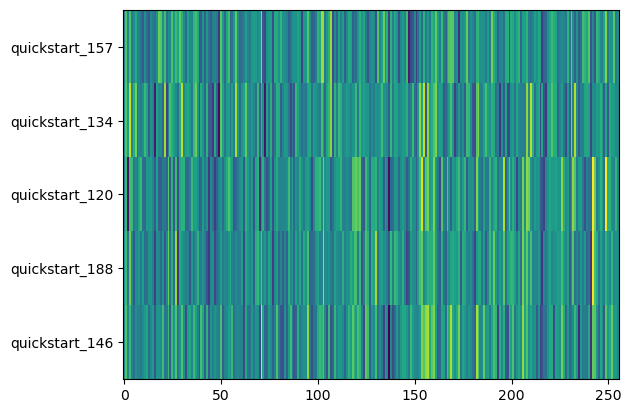

In [16]:
# Plot heatmap separating each row iwth boxes
plt.imshow(new_entry['embeds'], cmap="viridis", aspect="auto", interpolation="nearest")
# Set y tick labels
plt.yticks(range(len(new_entry['names'])), new_entry['names'])

## Retrieval using contrastive FPs

This assumes we have predefined a list of candidate smiles.


Note that this is not a very efficient implementation; see the scripts provided in quickstart that point to more efficient script implementations which use HDFs

In [17]:
# Contrastive embeddings
name_to_embed = {name: embed for name, embed in zip(new_entry['names'], new_entry['embeds'])}
name_to_formula = {name: formula for name, formula in zip(new_labels['spec'], new_labels['formula'])}

In [18]:
kwargs['mol_features'] = model.main_model.mol_features(mode="test")
kwargs['fp_names'] = contrast_model['hyper_parameters']['base_model_hparams']['fp_names']
paired_featurizer = featurizers.get_paired_featurizer(**kwargs)

In [19]:
# Extract candidate list file
smi_list = "../quickstart/lookup_smiles.txt"
all_smi = [i.strip() for i in open(smi_list, "r").readlines()]
forms = [utils.form_from_smi(i) for i in all_smi]
ikeys = [utils.inchikey_from_smiles(i) for i in all_smi]
form_to_smi = {i: [] for i in set(forms)}
for form, smi, ikey in zip(forms, all_smi, ikeys):
    form_to_smi[form].append((smi, ikey))

In [20]:
name_to_output = {}
for name, formula in name_to_formula.items():
    embed = name_to_embed[name]
    #print(name, formula, embed)
    candidates = form_to_smi[formula]
    print(name, formula, candidates)
    cand_smis, cand_ikeys = zip(*candidates)
    mol_list = [data.Mol.MolFromSmiles(i) for i in cand_smis]
    fp_list = [paired_featurizer.featurize_mol(i) for i in mol_list]
    fp_list = torch.from_numpy(np.vstack(fp_list)) 
    fp_loader = torch.utils.data.DataLoader(fp_list, batch_size=128, shuffle=False)
    encoded_mols = []
    with torch.no_grad():
            model = model.to(device)
            model = model.eval()
            for fp_batch in tqdm(fp_loader):
                batch = {"mols": fp_batch.to(device)}

                outputs = model.encode_mol(batch)
                contrast_out = outputs[1]["contrast"].detach().cpu()
                encoded_mols.append(contrast_out)
            stacked_mols = torch.cat(encoded_mols, 0).numpy()
    cos_dist = np.dot(embed, stacked_mols.T) / (np.linalg.norm(embed) * np.linalg.norm(stacked_mols, axis=1))
    arg_order = np.argsort(cos_dist)
    mol_list = np.array(cand_smis)[arg_order]
    name_to_output[name] = mol_list


quickstart_157 C8H15NO4 [('CC(NC(C(=O)O)C(C)C)C(=O)O', 'MHWYRGPPKCKIQY-UHFFFAOYSA-N'), ('OC1CN2CCC(O)C2C(O)C1O', 'JDVVGAQPNNXQDW-UHFFFAOYSA-N'), ('CCCCC(O)C(O)=NCC(=O)O', 'YQMRIHFIEQHCOJ-UHFFFAOYSA-N'), ('CC(O)C(=O)NC(C(=O)O)C(C)C', 'IJKKTQLUXOILBQ-UHFFFAOYSA-N'), ('CCCCC(NCC(=O)O)C(=O)O', 'MBBNCIKYWHIZGN-UHFFFAOYSA-N'), ('CCC(O)CCC(O)=NCC(=O)O', 'MRWDIRTUXFYBHJ-UHFFFAOYSA-N'), ('C[N+](C)(C)C(CCC(=O)O)C(=O)[O-]', 'WTIGXLNNRAGPIV-UHFFFAOYSA-N'), ('CCCC(O)CC(O)=NCC(=O)O', 'AYNJYFWPCLXDNL-UHFFFAOYSA-N'), ('CC(C)(C)OC(=O)CC(N)C(=O)O', 'MXWMFBYWXMXRPD-UHFFFAOYSA-N'), ('CC(O)CCCC(O)=NCC(=O)O', 'YAFMZZZZHXVTEJ-UHFFFAOYSA-N'), ('CN1C2CCC1(O)C(O)C(O)C2O', 'GZDWTPRPLBRISA-UHFFFAOYSA-N')]


100%|██████████| 1/1 [00:00<00:00, 1117.88it/s]


quickstart_134 C9H18N2O4 [('CCC(C)C(N)C(=O)NC(CO)C(=O)O', 'TWVKGYNQQAUNRN-UHFFFAOYSA-N'), ('CC(C)CC(N)C(O)=NC(CO)C(=O)O', 'XGDCYUQSFDQISZ-UHFFFAOYSA-N'), ('CCCC(C)(COC(N)=O)COC(N)=O', 'NPPQSCRMBWNHMW-UHFFFAOYSA-N'), ('CC(C)CC(N)(NC(C)C(=O)O)C(=O)O', 'HZOQMZBZPWLKIO-UHFFFAOYSA-N'), ('CC(C)CC(NC(=O)C(N)CO)C(=O)O', 'NFDYGNFETJVMSE-UHFFFAOYSA-N'), ('CC(C)C(NC(=O)C(N)C(C)O)C(=O)O', 'CKHWEVXPLJBEOZ-UHFFFAOYSA-N'), ('NCCCCC(NCCC(=O)O)C(=O)O', 'UENLDOJJKXLRJI-UHFFFAOYSA-N'), ('CC(C)C(N=C(O)C(N)C(C)O)C(=O)O', 'CKHWEVXPLJBEOZ-UHFFFAOYSA-N'), ('NC(CCCC(N)C(=O)O)CCC(=O)O', 'ALXLJPPLHFRKEJ-UHFFFAOYSA-N'), ('CC(NCCCCC(N)C(=O)O)C(=O)O', 'XCYPSOHOIAZISD-UHFFFAOYSA-N'), ('CC(C)(CO)C(O)C(=O)NCCC(N)=O', 'AMMYIDAXRNSZSJ-UHFFFAOYSA-N'), ('CCC(C)C(NC(=O)C(N)CO)C(=O)O', 'BXLYSRPHVMCOPS-UHFFFAOYSA-N'), ('NC(CCCCNCCC(=O)O)C(=O)O', 'SPBWCBIQZFYDOE-UHFFFAOYSA-N'), ('CC(C)C(N)C(=O)NC(C(=O)O)C(C)O', 'GVRKWABULJAONN-UHFFFAOYSA-N'), ('CC(NC(CCCCN)C(=O)O)C(=O)O', 'ZZYYVZYAZCMNPG-UHFFFAOYSA-N'), ('CCC(CC)(COC(N)=O)COC

100%|██████████| 1/1 [00:00<00:00, 1761.57it/s]


quickstart_120 C6H6N2O [('NC(=O)c1cccnc1', 'DFPAKSUCGFBDDF-UHFFFAOYSA-N'), ('ON=Cc1ccccn1', 'MTFJSAGADRTKCI-UHFFFAOYSA-N'), ('Nc1cccnc1C=O', 'QNJCRBZVUFRESB-UHFFFAOYSA-N'), ('NC(=O)c1ccncc1', 'VFQXVTODMYMSMJ-UHFFFAOYSA-N'), ('CC(=O)c1cnccn1', 'DBZAKQWXICEWNW-UHFFFAOYSA-N'), ('N=C(O)c1ccccn1', 'IBBMAWULFFBRKK-UHFFFAOYSA-N'), ('O=NCc1ccccn1', 'NZNHTKNELYIQNB-UHFFFAOYSA-N')]


100%|██████████| 1/1 [00:00<00:00, 1559.80it/s]


quickstart_188 C6H6N2O2 [('[O-][N+](=NO)c1ccccc1', 'PTPLXVHPKMTVIW-UHFFFAOYSA-N'), ('N#CCCn1ccc(=O)o1', 'DNSSEQBYSHSUGR-UHFFFAOYSA-N'), ('NC(=O)c1ccc[n+]([O-])c1', 'USSFUVKEHXDAPM-UHFFFAOYSA-N'), ('O=C(O)C=Cc1c[nH]cn1', 'LOIYMIARKYCTBW-UHFFFAOYSA-N'), ('NC(=O)c1cnccc1O', 'UDTVJEZIOILIRG-UHFFFAOYSA-N'), ('Nc1ccc([N+](=O)[O-])cc1', 'TYMLOMAKGOJONV-UHFFFAOYSA-N'), ('O=C(NO)c1cccnc1', 'IYCHDNQCHLMLJZ-UHFFFAOYSA-N'), ('Cc1cnc(C(=O)O)cn1', 'RBYJWCRKFLGNDB-UHFFFAOYSA-N'), ('O=[N+]([O-])Nc1ccccc1', 'VBEGHXKAFSLLGE-UHFFFAOYSA-N'), ('Nc1ncccc1C(=O)O', 'KPIVDNYJNOPGBE-UHFFFAOYSA-N'), ('Nc1cccnc1C(=O)O', 'BOOMHTFCWOJWFO-UHFFFAOYSA-N'), ('Nc1cccc(ON=O)c1', 'HGFVJSMTWKYHDQ-UHFFFAOYSA-N'), ('NC(=O)c1ccc(=O)[nH]c1', 'NGPNYDVHEUXWIA-UHFFFAOYSA-N'), ('Nc1cccc([N+](=O)[O-])c1', 'XJCVRTZCHMZPBD-UHFFFAOYSA-N'), ('O=C(O)C=Cc1cnc[nH]1', 'LOIYMIARKYCTBW-UHFFFAOYSA-N'), ('NC(=O)n1ccccc1=O', 'IZDSWWYQJKEPQW-UHFFFAOYSA-N')]


100%|██████████| 1/1 [00:00<00:00, 1548.86it/s]


quickstart_146 C7H7NO3 [('O=C(NO)c1ccccc1O', 'HBROZNQEVUILML-UHFFFAOYSA-N'), ('NOc1ccccc1C(=O)O', 'NBGAYCYFNGPNPV-UHFFFAOYSA-N'), ('Nc1ccc(C(=O)O)c(O)c1', 'WUBBRNOQWQTFEX-UHFFFAOYSA-N'), ('Cc1cc(O)ccc1[N+](=O)[O-]', 'PIIZYNQECPTVEO-UHFFFAOYSA-N'), ('COc1ccc(C(=O)O)cn1', 'NVDJVEQITUWZDT-UHFFFAOYSA-N'), ('Nc1ccc(O)c(C(=O)O)c1', 'KBOPZPXVLCULAV-UHFFFAOYSA-N'), ('Cc1ccc(O)c([N+](=O)[O-])c1', 'SYDNSSSQVSOXTN-UHFFFAOYSA-N'), ('Nc1cccc(C(=O)O)c1O', 'IQGMRVWUTCYCST-UHFFFAOYSA-N'), ('Nc1cc(O)cc(C(=O)O)c1', 'QPEJHSFTZVMSJH-UHFFFAOYSA-N'), ('Nc1cc(C(=O)O)ccc1O', 'MRBKRZAPGUCWOS-UHFFFAOYSA-N'), ('COc1ccc([N+](=O)[O-])cc1', 'BNUHAJGCKIQFGE-UHFFFAOYSA-N'), ('O=[N+]([O-])c1ccc(CO)cc1', 'JKTYGPATCNUWKN-UHFFFAOYSA-N'), ('NC(=O)C1=C(C=O)C=CCO1', 'JTLUWNHUNIMIFA-UHFFFAOYSA-N'), ('NC(=O)c1cc(O)ccc1O', 'FRXZIFVYTNMCHF-UHFFFAOYSA-N'), ('Nc1c(O)cccc1C(=O)O', 'WJXSWCUQABXPFS-UHFFFAOYSA-N')]


100%|██████████| 1/1 [00:00<00:00, 1591.16it/s]


quickstart_157 C8H15NO4


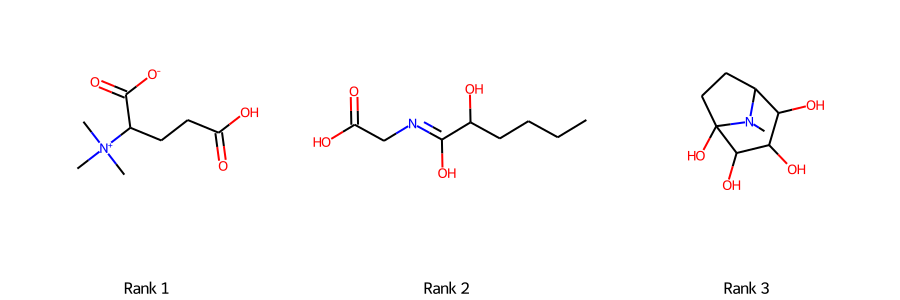




quickstart_134 C9H18N2O4


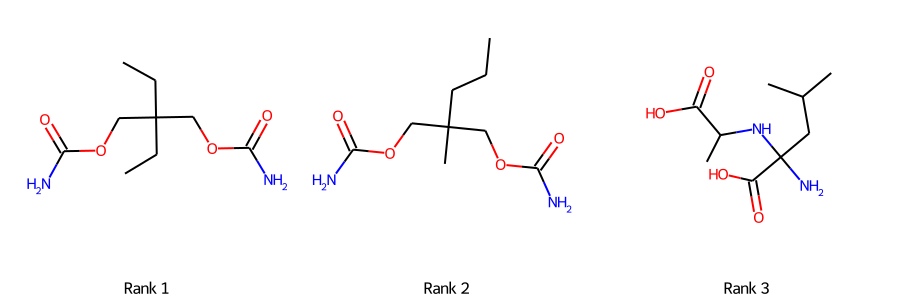




quickstart_120 C6H6N2O


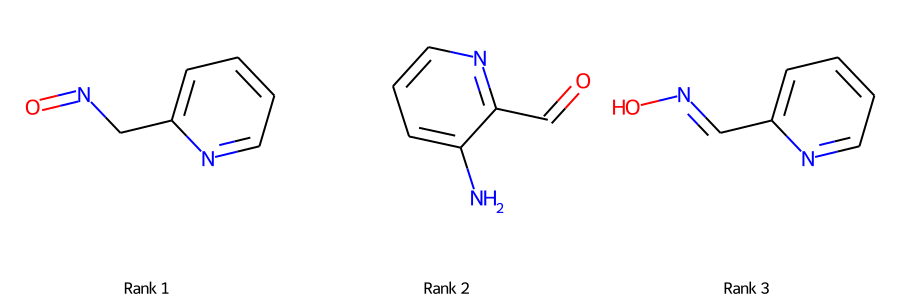




quickstart_188 C6H6N2O2


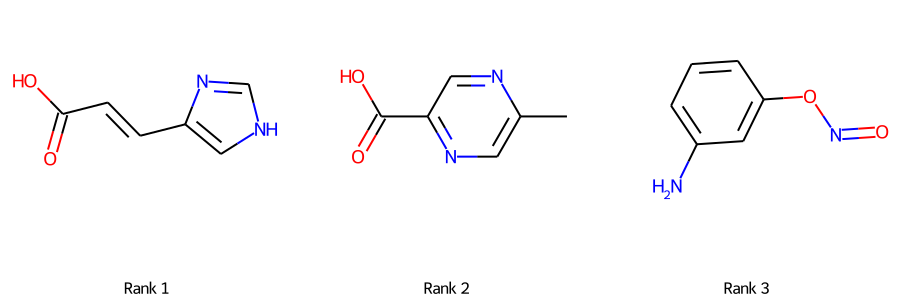




quickstart_146 C7H7NO3


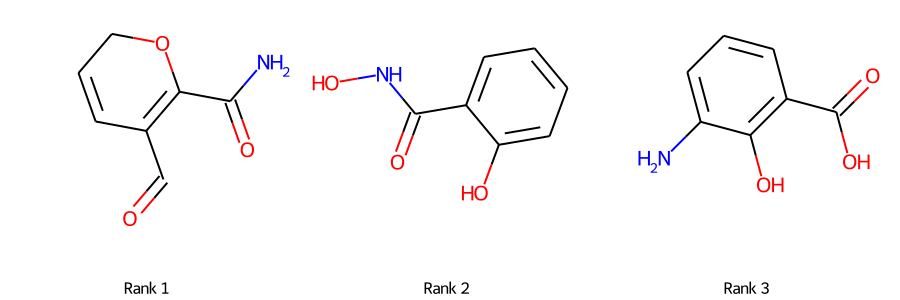

In [21]:
for k, v in name_to_output.items():
    # Print name and formula
    print(k, name_to_formula[k])
    # Display top 3 smiles using rdkit Chem mol to grid images
    if len(v) == 0:
        print("No cands for this formula")
        continue
    mol_objs = [Chem.MolFromSmiles(i) for i in v[:3]]
    # Add text below for rank
    img = Draw.MolsToGridImage(mol_objs, molsPerRow=3, subImgSize=(300, 300)
                                 , legends=[f"Rank {i+1}" for i in range(len(mol_objs))]
                               )
    display(img)
    print("\n\n")